# 2022-10-13 • Find non-lognormal firing rates  

The direct scientific motivation is to fix the error discovered in the N-to-1 simulations, where the Poisson inputs' firing rates turned out not to be lognormal, as was desired.

When writing the network simulation code, the N-to-1 simulation code was copied and adapted.
I.e. there is duplication in functionality, and divergence in their APIs.
It's time for consolidation.
Advantage: easier to also investigate LIF/EIF neurons, different neuron types, etc.

## Imports

In [1]:
#

In [2]:
using MyToolbox

In [3]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]
[ Info: Skipping precompilation since __precompile__(false). Importing VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e].


## Poisson spikes

Spikes at constant mean rate and independent of last spike.

pdf of num spikes:

$$P(k \text{ spikes over duration } T) = \frac{λ^k e^{-λ}}{k!} \ \ \text{ with } λ = rT$$

($r$ is spikes / second).

So could evaluate this at every timestep, i.e. for $T$ = `Δt`.

That's silly ofc, you'd have to do it for k = 0, 1, …

So we use the property that for a Poisson process*, the inter-arrival times are exponentially distributed [1][1]

*In a Poisson process of length T, the number of events is $\sim \text{Pois}(rT)$.

[1]: https://www.wikiwand.com/en/Poisson_distribution#:~:text=the%20sequence%20of%20inter%2Darrival%20times

(Note that on [Poisson_distribution](https://en.wikipedia.org/wiki/Poisson_distribution), λ = number of events, r = rate.  
 But on [Exponential_distribution](https://en.wikipedia.org/wiki/Exponential_distribution), λ = rate.)

So ISIs $\sim \text{Exp}(r)$

On to Distributions.jl.\
They parametrize with scale θ (on wp: β), = 1/λ.

In [4]:
spike_rate = 20Hz   # λ
mean_ISI = 1/spike_rate  # β
ISI_distr = Exponential(mean_ISI)

ISIs = rand(ISI_distr, 20)
to_spiketimes(ISIs) = cumsum(ISIs)
to_spiketimes(ISIs);

Now, I want to fill a set interval with spikes.

In [6]:

function gen_Poisson_spikes(r, T)
    # The number of spikes N in a time interval [0, T] is ~ Poisson(mean = rT)
    # <--> Inter-spike-intervals ~ Exponential(rate = r).
    # 
    # We simulate the Poisson process by drawing such ISIs, and accumulating them until we
    # reach T. We cannot predict how many spikes we will have at that point. Hence, we
    # allocate an array long enough to very likely fit all of them, and trim off the unused
    # end upon reaching T.
    # 
    max_N = cquantile(Poisson(r*T), 1e-14)  # complementary quantile. [1]
    spikes = Vector{Float64}(undef, max_N)
    ISI_distr = Exponential(inv(r))         # Parametrized by scale = 1 / rate
    N = 0
    t = rand(ISI_distr)
    while t ≤ T
        N += 1
        spikes[N] = t
        t += rand(ISI_distr)
    end
    resize!(spikes, N)
end
# [1] If the provided probability is smaller than ~1e15, we get an error (`Inf`):
#     https://github.com/JuliaStats/Rmath-julia/blob/master/src/qpois.c#L86
#     For an idea of the expected overhead of creating a roomy array: for r = 100 Hz and T =
#     10 minutes, the expected N is 60000, and max_N is 61855.


T = 10minutes
gen_Poisson_spikes(100Hz, T);

In [10]:
spikerate(spikes, duration = T) = length(spikes) / duration / Hz;

In [12]:
@show gen_Poisson_spikes(0.1Hz, T) |> spikerate
@show gen_Poisson_spikes(10Hz, T) |> spikerate
;

gen_Poisson_spikes(0.1Hz, T) |> spikerate = 0.107
gen_Poisson_spikes(10Hz, T) |> spikerate = 10.1


## LogNormal firing rates

In [13]:
λ_distr = LogNormal_with_mean(4Hz, 2)
quantile(λ_distr, [0.1, 0.9])

2-element Vector{Float64}:
 0.0417
 7.02

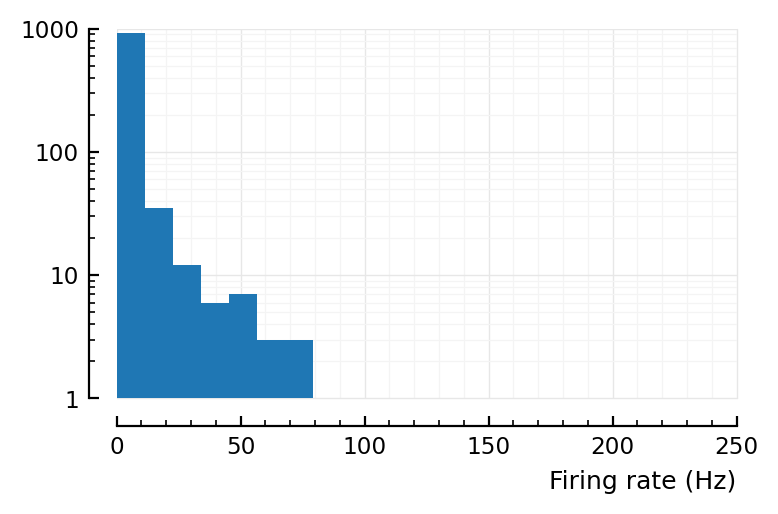

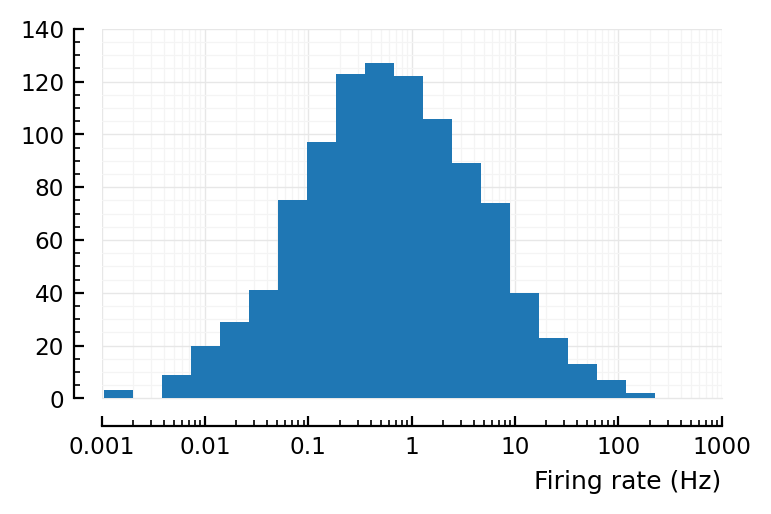

In [15]:
function xloghist(x, nbins = 20; kw...)
    fig, ax = plt.subplots()
    a, b = extrema(x)
    bins = 10 .^ range(log10(a), log10(b), nbins)
    ax.hist(x; bins)
    set(ax, xscale = :log; kw...)
end

function yloghist(x, nbins = 20; kw...)
    fig, ax = plt.subplots()
    ax.hist(x, bins = nbins, log = true)
    set(ax; kw...)
end

input_fr = rand(λ_distr, 1000)
xlabel = "Firing rate (Hz)"
yloghist(input_fr; xlabel)
xloghist(input_fr; xlabel)

^ that's desired firing rates.

Now to sim the poisson process..

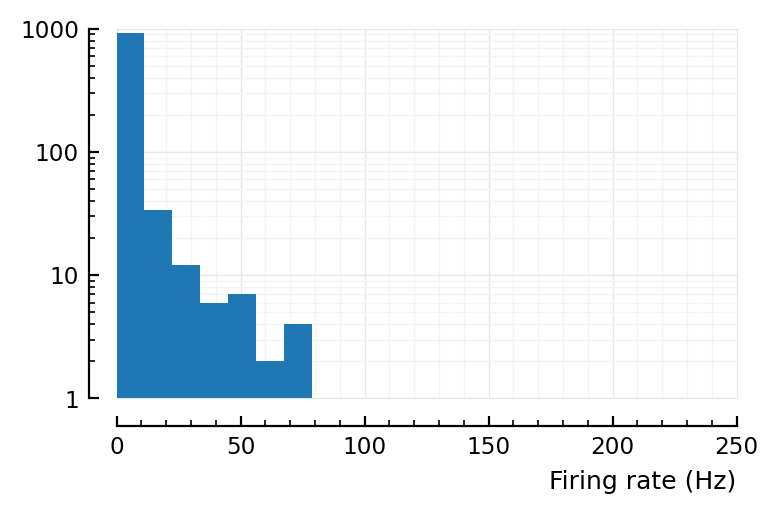

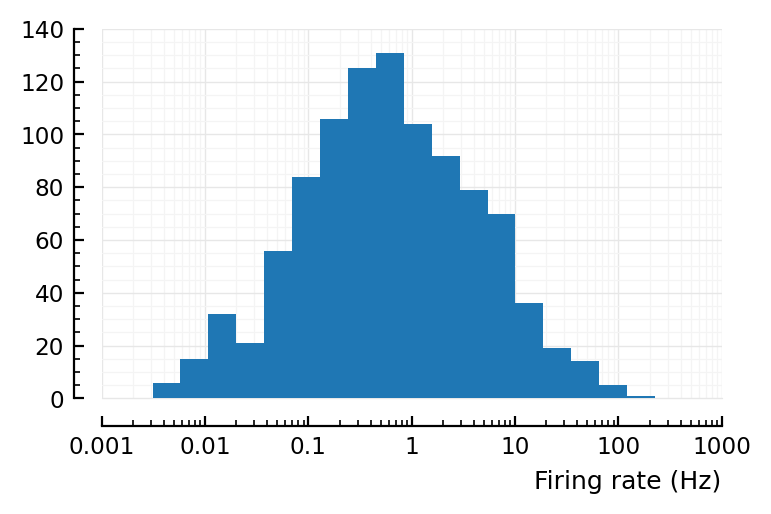

In [17]:
actual_rates = [spikerate(gen_Poisson_spikes(λ, T)) for λ in input_fr]
yloghist(actual_rates; xlabel)
xloghist(actual_rates; xlabel)

Wut.

Now it works.

(Compare with [here](https://tfiers.github.io/phd/nb/2022-10-11__Nto1_output_rate__Edit_of_2022-05-02.html#inputs-firing-rates-distribution:~:text=plt.hist(length.(s.input_spikes)%20/%20p.sim.duration%20/%20Hz%2C%20bins%3D20)%3B))

Copy paste last N-to-1 sim code, see if it has the bug.

## Debug old code

This is from `src/sim/Nto1/`, with irrelevant code (v, u, g diffeqs; connections) pruned out.

https://github.com/tfiers/phd/tree/da6bc5/pkg/VoltageToMap/src

In [33]:
module ToDebug

using ..VoltoMapSim

const default_rngseed = 22022022
@with_kw struct PoissonInputParams
    N_unconn     ::Int            = 100
    N_exc        ::Int            = 5200
    N_inh        ::Int            = N_exc ÷ 4
    N_conn       ::Int            = N_inh + N_exc
    N            ::Int            = N_conn + N_unconn
    spike_rates  ::Distribution   = LogNormal_with_mean(4Hz, √0.6)  # (μₓ, σ)
end
const realistic_N_6600_input = PoissonInputParams()
const previous_N_30_input    = PoissonInputParams(N_unconn = 9, N_exc = 17)
@with_kw struct SimParams
    duration       ::Float64                = 10 * seconds
    Δt             ::Float64                = 0.1 * ms
    num_timesteps  ::Int                    = round(Int, duration / Δt)
    rngseed        ::Int                    = default_rngseed
    input          ::PoissonInputParams     = realistic_N_6600_input
end

function init_Nto1_sim(p::SimParams)
    
    @unpack N_unconn, N_exc, N_inh = p.input

    # IDs, subgroup names.
    input_neuron_IDs = idvec(conn = idvec(exc = N_exc, inh = N_inh), unconn = N_unconn)
    var_IDs          = idvec(t = scalar)

    resetrng!(p.rngseed)

    # Inter-spike—interval distributions
    λ = similar(input_neuron_IDs, Float64)
    λ .= rand(p.input.spike_rates, length(λ))
    β = 1 ./ λ
    ISI_distributions = Exponential.(β)

    # Input spikes queue
    first_input_spike_times = rand.(ISI_distributions)
    upcoming_input_spikes   = PriorityQueue{Int, Float64}()
    for (n, t) in zip(input_neuron_IDs, first_input_spike_times)
        enqueue!(upcoming_input_spikes, n => t)
    end

    # Allocate memory to be overwritten every simulation step.
    vars = similar(var_IDs, Float64)
    vars.t = zero(p.duration)
    diff = similar(vars)  # = ∂x/∂t for every x in `vars`
    diff.t = 1 * seconds/seconds

    # Where to record to
    input_spikes = similar(input_neuron_IDs, Vector{Float64})
    for i in eachindex(input_spikes)
        input_spikes[i] = Vector{Float64}()
    end

    return (
        state = (
            fixed_at_init    = (; ISI_distributions),
            variable_in_time = (; vars, diff, upcoming_input_spikes),
        ),
        rec   = (; input_spikes),
    )
end

function step_Nto1_sim!(state, params::SimParams, rec, i)

    @unpack ISI_distributions      = state.fixed_at_init
    @unpack vars, diff, upcoming_input_spikes  = state.variable_in_time
    @unpack t                      = vars
    @unpack Δt                     = params

    @. vars += diff * Δt
    # lil bug here: `t` below is the one of the previous time step.

    t_next_input_spike = peek(upcoming_input_spikes).second  # (.first is neuron ID).
    if t ≥ t_next_input_spike
        n = dequeue!(upcoming_input_spikes)  # ID of the fired input neuron
        push!(rec.input_spikes[n], t)
        # ..
        tn = t + rand(ISI_distributions[n])  # Next spike time for the fired neuron
        enqueue!(upcoming_input_spikes, n => tn)
    end
end

function sim_Nto1(params::SimParams)
    state, rec = init_Nto1_sim(params)
    @unpack duration, num_timesteps = params
    @showprogress "Running simulation: " (
    for i in 1:num_timesteps
        step_Nto1_sim!(state, params, rec, i)
    end)
    return (; rec.input_spikes, state)
end

end
using .ToDebug

p = ToDebug.SimParams(duration = 10minutes)
spikes, state = ToDebug.sim_Nto1(p);

Running simulation: 100%|███████████████████████████████| Time: 0:00:04


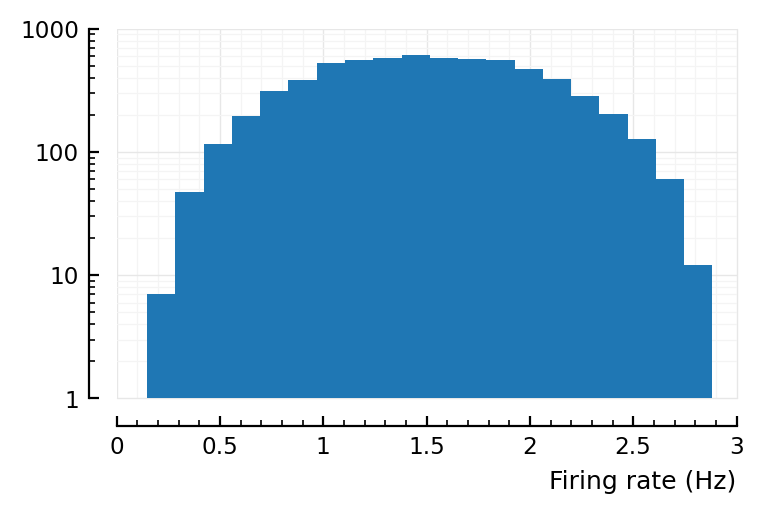

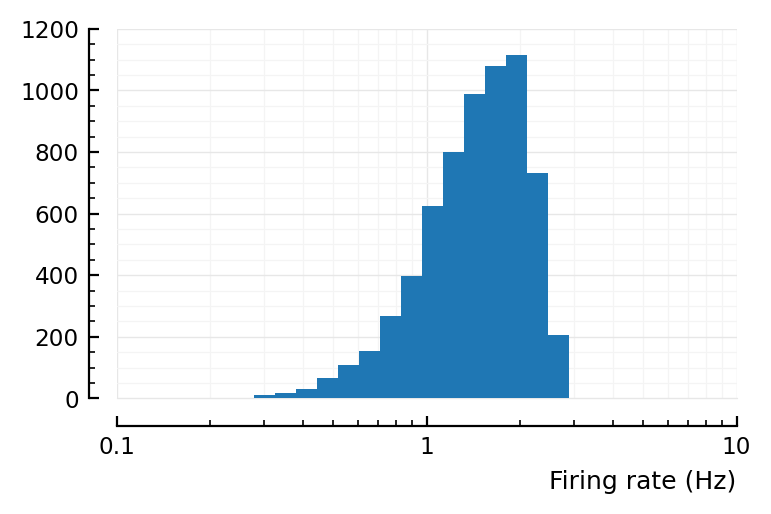

In [37]:
actual_rates_old = spikerate.(spikes)
yloghist(actual_rates_old; xlabel)
xloghist(actual_rates_old; xlabel)

Alright, so the problem is reproducible at least, good.

Maybe the diff is cause σ too small?

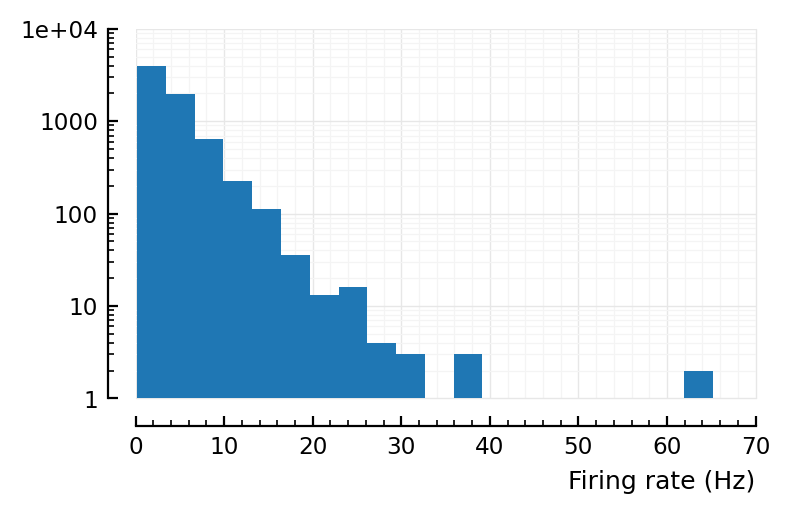

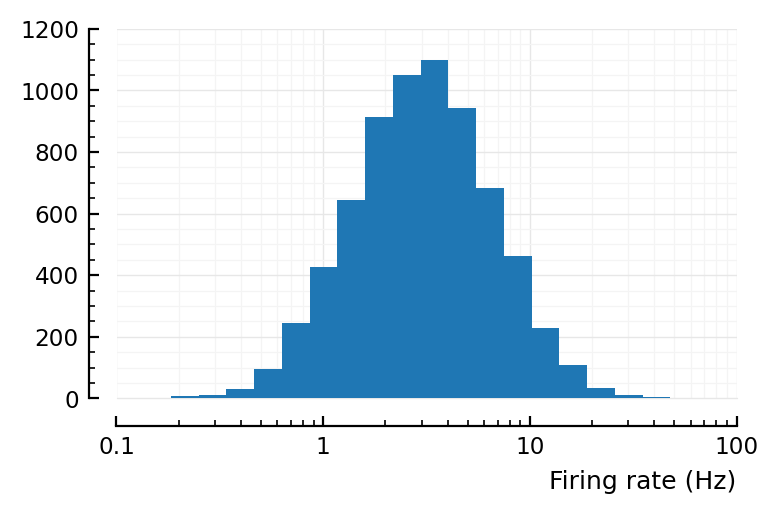

In [22]:
λs_same_as_old = rand(LogNormal_with_mean(4Hz, √0.6), 7000)
r = [spikerate(gen_Poisson_spikes(λ, T)) for λ in λs_same_as_old]
yloghist(r; xlabel)
xloghist(r; xlabel)

No.

What is range of input firing rates?

In [36]:
extrema(rate.(state.fixed_at_init.ISI_distributions) / Hz)

(0.178, 49.6)

So in our left plot above `yloghist(actual_rates_old; xlabel)`, max should be at 50Hz, not 2.9Hz.

Try.. step through a simple example.

In [91]:
input = ToDebug.PoissonInputParams(N_unconn = 2, N_exc = 0)

p = ToDebug.SimParams(; input)

s, rec = ToDebug.init_Nto1_sim(p)


s.fixed_at_init.ISI_distributions[1] = Exponential(1/0.178Hz)
s.fixed_at_init.ISI_distributions[2] = Exponential(1/49.7Hz)
# The first two events in 
s.variable_in_time.upcoming_input_spikes
# ..are now not correct. But that's fine; subsequent will.

mean_ISIs = scale.(collect(s.fixed_at_init.ISI_distributions))
# set_print_precision("4f")
@show mean_ISIs

for i in 1:p.num_timesteps
    ToDebug.step_Nto1_sim!(s, p, rec, i)
end

# @show s.variable_in_time.vars.t collect(rec.input_spikes)

spikerate.([rec.input_spikes;], p.duration)

mean_ISIs = [5.6180, 0.0201]


2-element Vector{Float64}:
  0.1000
 52.2000

Alright, that is good and as expected.

But if we do it as follows, it's wrong

In [93]:
pfull = ToDebug.SimParams(duration = 10minutes)
spikes, state = ToDebug.sim_Nto1(pfull);
extrema(spikerate.([spikes;], pfull.duration))

Running simulation: 100%|███████████████████████████████| Time: 0:00:04


(0.1483, 2.8833)

cause:

In [94]:
extrema(rate.(state.fixed_at_init.ISI_distributions))

(0.1778, 49.6098)

(So the lower end is kinda fine. It's the high spiking that's wrong).

Ah. Problem found.

I put it in comment:
```
Unhandled edge case: multiple spikes in the same time bin get processed with
increasing delay. (This problem goes away when using diffeq.jl, `adaptive`).
```
..and I'd assumed that was fine.
But if you share one queue between 7000 inputs, then yeah.

Ach, ach.

I bet if we look at queue, it's gonna be backed up.

Ah it cannot even have a backed up queue, as there can be just one entry per key (neuron ID).

In [ ]:
set_print_precision("4f")

In [145]:
state.variable_in_time.vars.t - pfull.Δt

599.9999

In [142]:
state.variable_in_time.upcoming_input_spikes

PriorityQueue{Int64, Float64, Base.Order.ForwardOrdering} with 6600 entries:
  5020 => 599.6734
  3711 => 599.6735
  4815 => 599.6737
  1701 => 599.6737
  2689 => 599.6738
  4440 => 599.6738
  1286 => 599.6738
  6517 => 599.6741
  457  => 599.6744
  4748 => 599.6750
  3674 => 599.6751
  2513 => 599.6752
  1720 => 599.6753
  3421 => 599.6753
  3493 => 599.6753
  3643 => 599.6753
  4823 => 599.6753
  395  => 599.6754
  415  => 599.6755
  244  => 599.6755
  2861 => 599.6756
  6037 => 599.6756
  946  => 599.6758
  207  => 599.6760
  5389 => 599.6761
  ⋮    => ⋮

In [146]:
9999-6734

3265

Ok the queue is kinda backed up: `t` is already at the 599.9999 timestep,  
but the there are still unprocessed spikes from up to 3265 timesteps back.

So there is no overwriting as above, but there is just minimum processing time.
Say it does all 7000 inputs after each other, then maximum firing rate is once every 7000 timesteps, or 1/700ms = 1.4 Hz.

That's where the mean of the ylog hist lies.
The higher effective firing rates (up to 3Hz) are then due to chance.


Conclusion: 
- I found the bug.
- Bug was not present in the (newer) network code (there, spike queue keeps being processed while there are any non-future spikes left; instead of processing just one as in the here debugged code).
- Why was bug there? Wrong implicit assumption.
    - "This spike queueing code will be used for just a few input Poisson neurons stimulating our neuron"
      -> so it was justified to not care about the edge case of multiple spikes per timestep, as they are rare there.
    - But then later, we upscaled our simulation, where this wasn't justified any longer: 6500 inputs at mean rate of 4 Hz is 2.6 spikes per Δt = 0.1 ms (!!)
        - and as the code was already there and 'working', I didn't look at it anymore.
        
- Learnings:
    - An automated test (here: test whether output distribution matches input specification) would have caught it.
      I "just looked at it" to test, and that was indeed fine; but all these little manual inspections.. you do it just once.
      Can't catch 'regressions'. When changing code, and in this case the code wasn't changed (!), just the params.
      - This corresponds to an automated test _suite_: test our assumptions over whole range of params.
      - ...so what would other assumptions be.
          - i.g: look at 'sanity check' plots in prev notebooks. Quantize them.